#### Получение котировок акций через API Тинькофф Инвестиций

In [45]:
import os
TOKEN = os.environ["INVEST_TOKEN"]


In [46]:
# подключение к API Тинькофф Инвестиций
import os
import datetime as dt
from tinkoff.invest import CandleInterval, Client
from tinkoff.invest.utils import now
import pandas as pd
from datetime import timedelta

sber_prices = []
sber_datetime = []
lkoh_prices = []
lkoh_datetime = []


# BBG004730N88 - SBER
# BBG004731032 - LKOH
def main():
    with Client(TOKEN) as client:
        for candle in client.get_all_candles(
            figi="BBG004730N88",
            from_=now() - timedelta(days=60),
            interval=CandleInterval.CANDLE_INTERVAL_DAY):
            
            # считаем как среднее между ценой открытия и закрытия
            sber_prices.append((candle.open.units + candle.close.units) / 2)
            sber_datetime.append(candle.time.date())
            
            
        for candle in client.get_all_candles(
            figi="BBG004731032",
            from_=now() - timedelta(days=60),
            interval=CandleInterval.CANDLE_INTERVAL_DAY):
            
            # считаем как среднее между ценой открытия и закрытия
            lkoh_prices.append((candle.open.units + candle.close.units) / 2)
            lkoh_datetime.append(candle.time.date())

    return 0


if __name__ == "__main__":
    main()

In [47]:
sber_quotes = pd.DataFrame({'Datetime': sber_datetime, 'Price': sber_prices})
lkoh_quotes = pd.DataFrame({'Datetime': lkoh_datetime, 'Price': lkoh_prices})

In [48]:
result_sber_price = sber_quotes[sber_quotes.Datetime == dt.datetime(2023, 5, 17).date()].Price.iloc[0]
result_lkoh_price = lkoh_quotes[lkoh_quotes.Datetime == dt.datetime(2023, 5, 17).date()].Price.iloc[0]
print('SBER 2023-05-17 :', result_sber_price)
print('LKOH 2023-05-17 :', result_lkoh_price)

SBER 2023-05-17 : 229.5
LKOH 2023-05-17 : 5095.5


#### Выплаты по опционам

In [49]:
df_sber = pd.read_csv('Results/sber_final_prices.csv')
df_lkoh = pd.read_csv('Results/lkoh_final_prices.csv')

In [50]:
import numpy as np
df_sber['Payoff'] = (result_sber_price - df_sber['Strike']).apply(lambda x: max(x, 0))
df_lkoh['Payoff'] = (result_lkoh_price - df_lkoh['Strike']).apply(lambda x: max(x, 0))

In [51]:
r = 0.0715     #дюрация 0.1 => процентная ставка 7,15% годовых (ставка ЦБ на 9 апреля 2023 года)
T = 38 / 365   #дней до экспирации опциона 
df_sber['Discount Payoff'] = df_sber['Payoff'] * np.exp(-r * T)
df_lkoh['Discount Payoff'] = df_lkoh['Payoff'] * np.exp(-r * T)

In [52]:
df_sber['Profit'] = df_sber['Payoff'] - df_sber['Price']
df_lkoh['Profit'] = df_lkoh['Payoff'] - df_lkoh['Price']

In [53]:
df_sber['Return, %'] = (round(df_sber['Profit']/df_sber['Price'] * 100, 1)).astype(str)
df_lkoh['Return, %'] = (round(df_lkoh['Profit']/df_lkoh['Price'] * 100, 1)).astype(str)

In [54]:
df_sber['Sharp Ratio'] = (df_sber['Profit']/df_sber['Price'] - ((1 + r)**(38/365) - 1)) / df_sber['IV']
df_lkoh['Sharp Ratio'] = (df_lkoh['Profit']/df_lkoh['Price'] - ((1 + r)**(38/365) - 1)) / df_lkoh['IV']

In [55]:
df_sber

,Price,Strike,IV,MC Price,BMCRR Price,BMJR Price,Payoff,Discount Payoff,Profit,"Return, %",Sharp Ratio
0,88.95,130.0,1.0769,88.863743,88.854575,88.856090,99.5,98.762088,10.55,11.9,0.103436
1,84.14,135.0,1.0289,84.068798,84.028005,84.026363,94.5,93.799169,10.36,12.3,0.112657
2,79.34,140.0,0.9826,79.214943,79.214861,79.215487,89.5,88.836250,10.16,12.8,0.122981
3,74.55,145.0,0.9382,74.438997,74.421430,74.421733,84.5,83.873331,9.95,13.3,0.134568
4,69.80,150.0,0.8957,69.646615,69.653715,69.655441,79.5,78.910412,9.70,13.9,0.147095
5,65.09,155.0,0.8554,64.936263,64.924149,64.927352,74.5,73.947493,9.41,14.5,0.160572
6,60.41,160.0,0.8172,60.257848,60.236527,60.240733,69.5,68.984574,9.09,15.0,0.175301
7,55.80,165.0,0.7812,55.596178,55.603663,55.607618,64.5,64.021655,8.70,15.6,0.190346
8,51.25,170.0,0.7476,51.030539,51.042661,51.043386,59.5,59.058736,8.25,16.1,0.205671
9,46.79,175.0,0.7162,46.537099,46.562409,46.559552,54.5,54.095817,7.71,16.5,0.219999


In [56]:
df_lkoh

,Price,Strike,IV,MC Price,BMCRR Price,BMJR Price,Payoff,Discount Payoff,Profit,"Return, %",Sharp Ratio
0,1557.29,3100.0,0.8260,1552.107515,1551.619557,1551.610778,1995.5,1980.700975,438.21,28.1,0.331933
1,1462.73,3200.0,0.7982,1456.781324,1456.716931,1456.724669,1895.5,1881.442595,432.77,29.6,0.361625
2,1369.10,3300.0,0.7722,1362.649107,1362.688848,1362.745959,1795.5,1782.184215,426.40,31.1,0.393978
3,1276.62,3400.0,0.7481,1270.260710,1269.858371,1269.886120,1695.5,1682.925835,418.88,32.8,0.428954
4,1185.54,3500.0,0.7258,1178.640136,1178.392738,1178.340067,1595.5,1583.667455,409.96,34.6,0.466498
5,1096.14,3600.0,0.7054,1088.064508,1088.496515,1088.565456,1495.5,1484.409075,399.36,36.4,0.506262
6,1008.77,3700.0,0.6867,1000.527113,1000.748541,1000.737320,1395.5,1385.150694,386.73,38.3,0.547768
7,923.78,3800.0,0.6699,915.649496,915.229204,915.293797,1295.5,1285.892314,371.72,40.2,0.589901
8,841.61,3900.0,0.6548,832.564215,832.695595,832.675071,1195.5,1186.633934,353.89,42.0,0.631148
9,762.67,4000.0,0.6414,753.115626,753.298355,753.311265,1095.5,1087.375554,332.83,43.6,0.669138


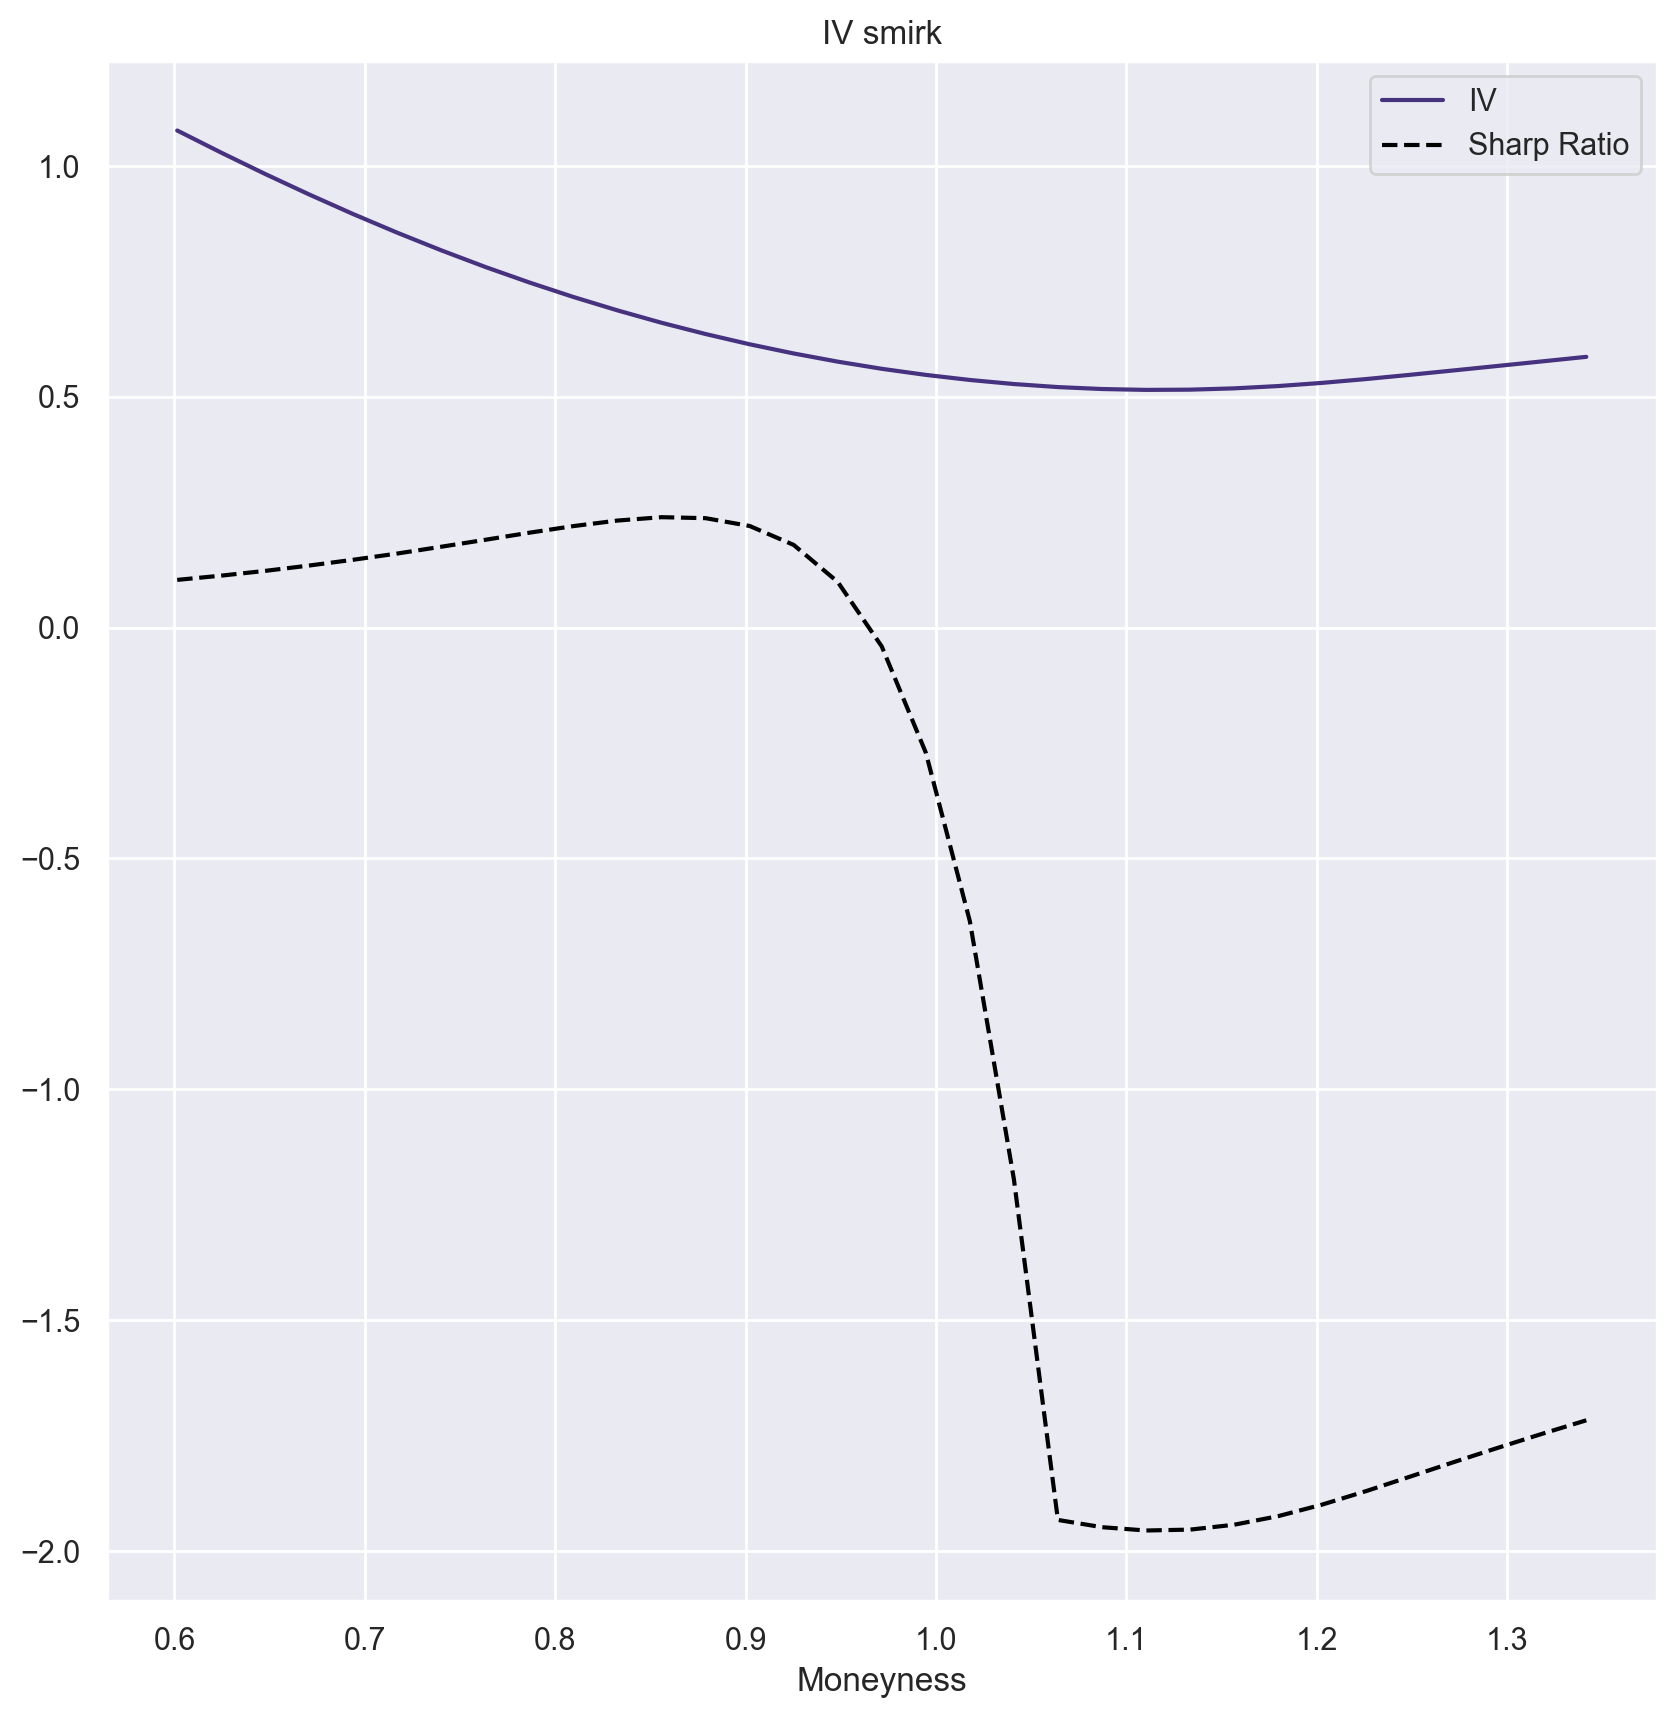

In [57]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sns.set(palette = 'viridis')
fig = plt.figure(figsize=(10, 10)) 

F0_sber = 216.1500
F0_lkoh = 4600

plt.title('IV smirk')
plt.plot(df_sber['Strike'] / F0_sber, df_sber['IV'], label = 'IV')
plt.plot(df_sber['Strike'] / F0_sber, df_sber['Sharp Ratio'], 'k--', label = 'Sharp Ratio')
plt.legend()
plt.ylabel('')
plt.xlabel('Moneyness')
plt.show()

# fig.savefig('IV&Sharp_SBER.png')

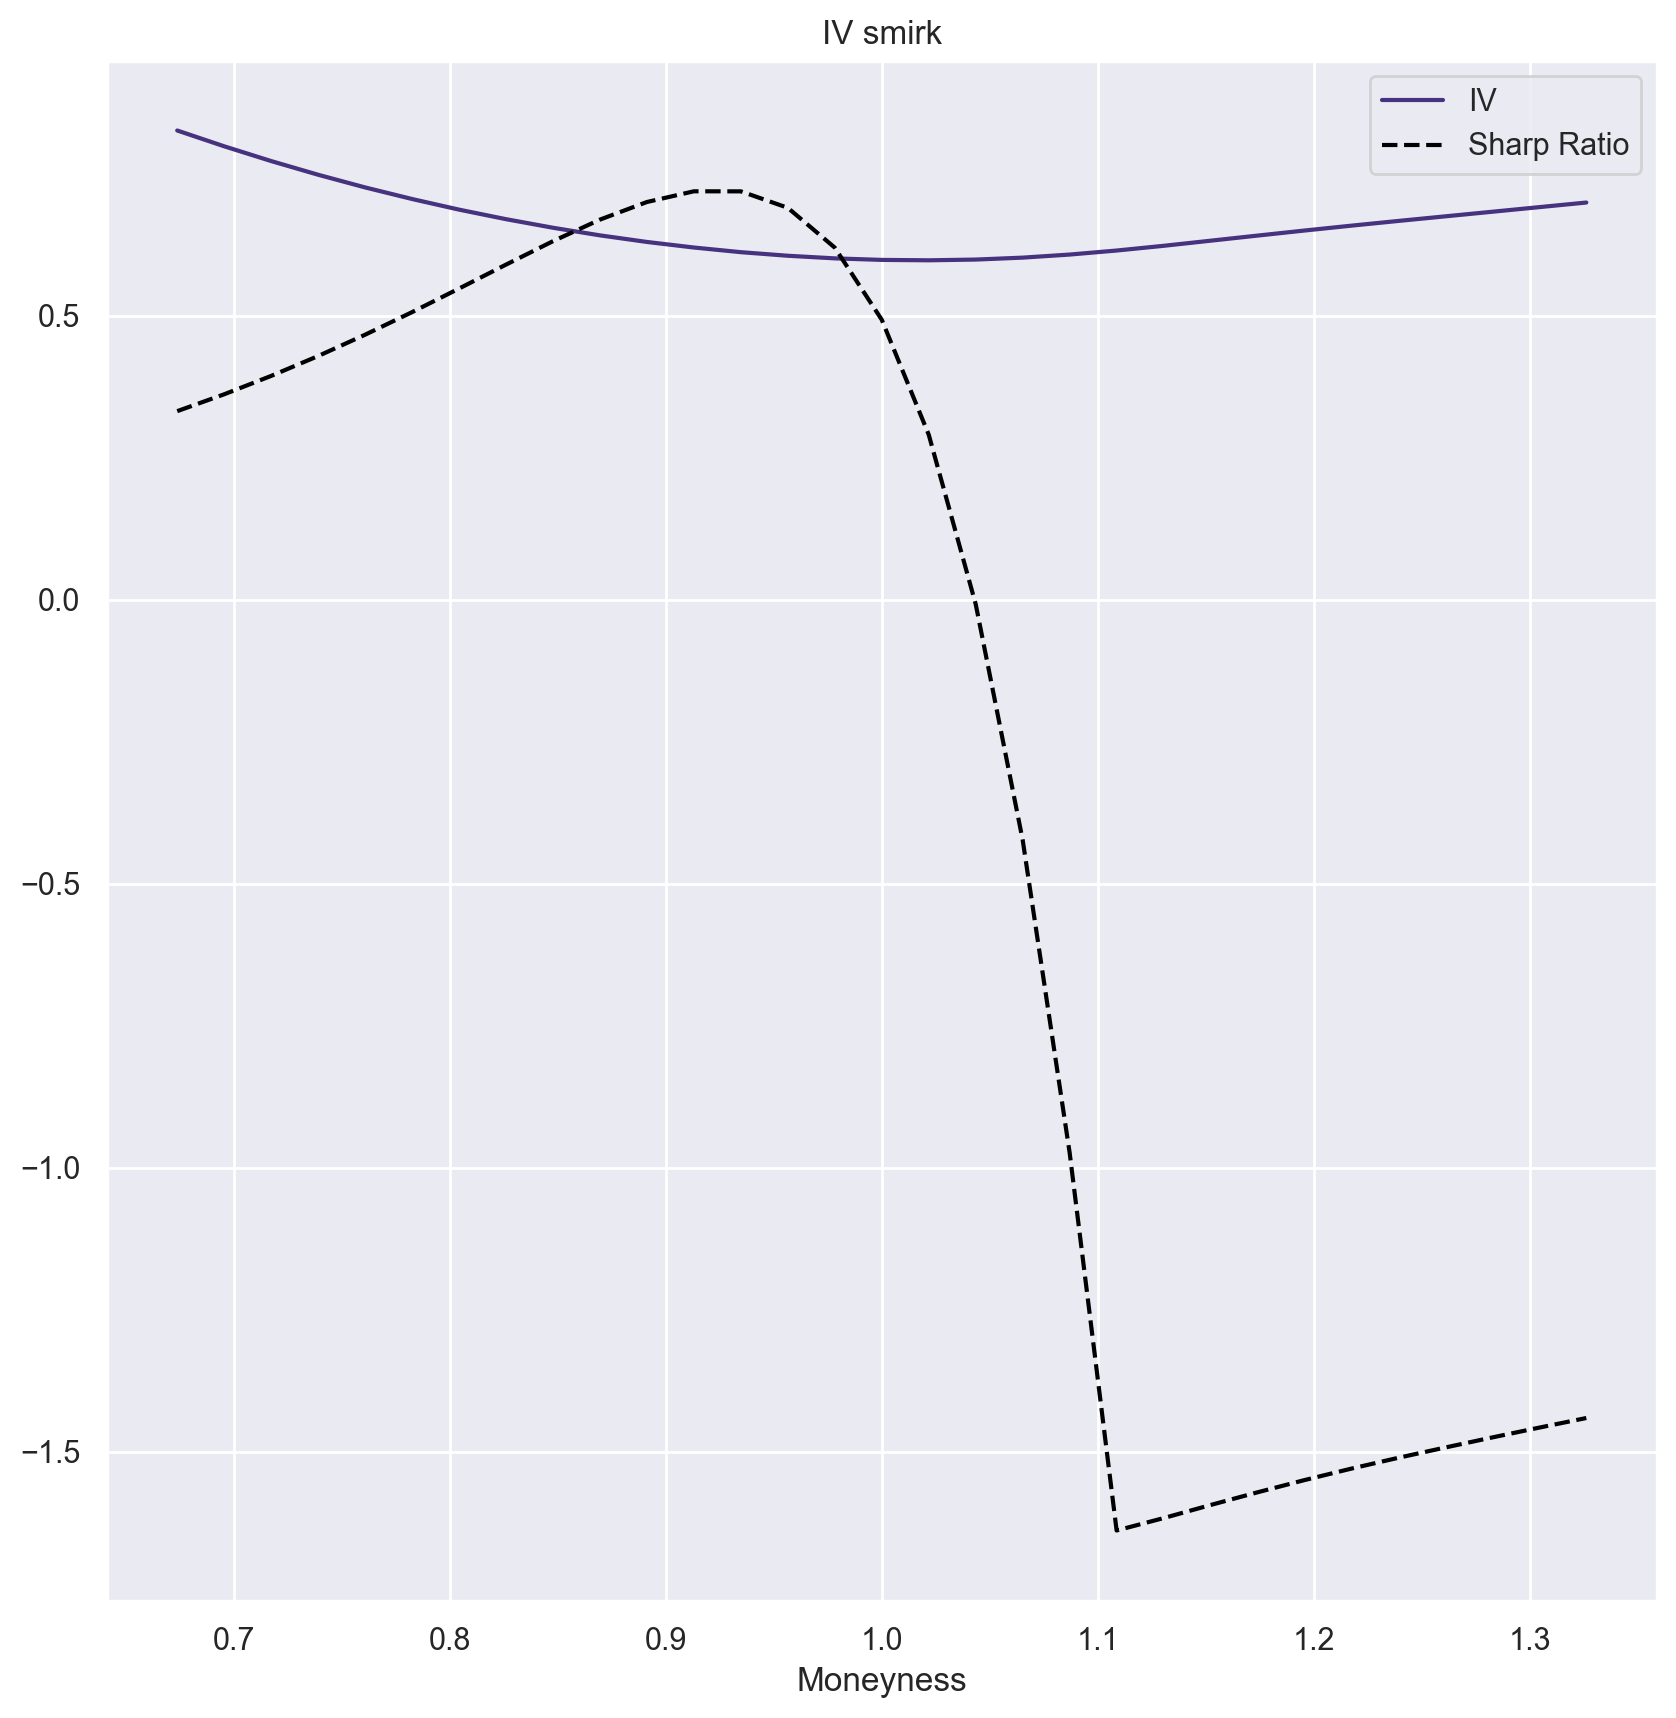

In [58]:
fig = plt.figure(figsize=(10, 10)) 

F0_sber = 216.1500
F0_lkoh = 4600

plt.title('IV smirk')
plt.plot(df_lkoh['Strike'] / F0_lkoh, df_lkoh['IV'], label = 'IV')
plt.plot(df_lkoh['Strike'] / F0_lkoh, df_lkoh['Sharp Ratio'], 'k--', label = 'Sharp Ratio')
plt.legend()
plt.ylabel('')
plt.xlabel('Moneyness')

plt.show()
# fig.savefig('IV&Sharp_LKOH.png')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


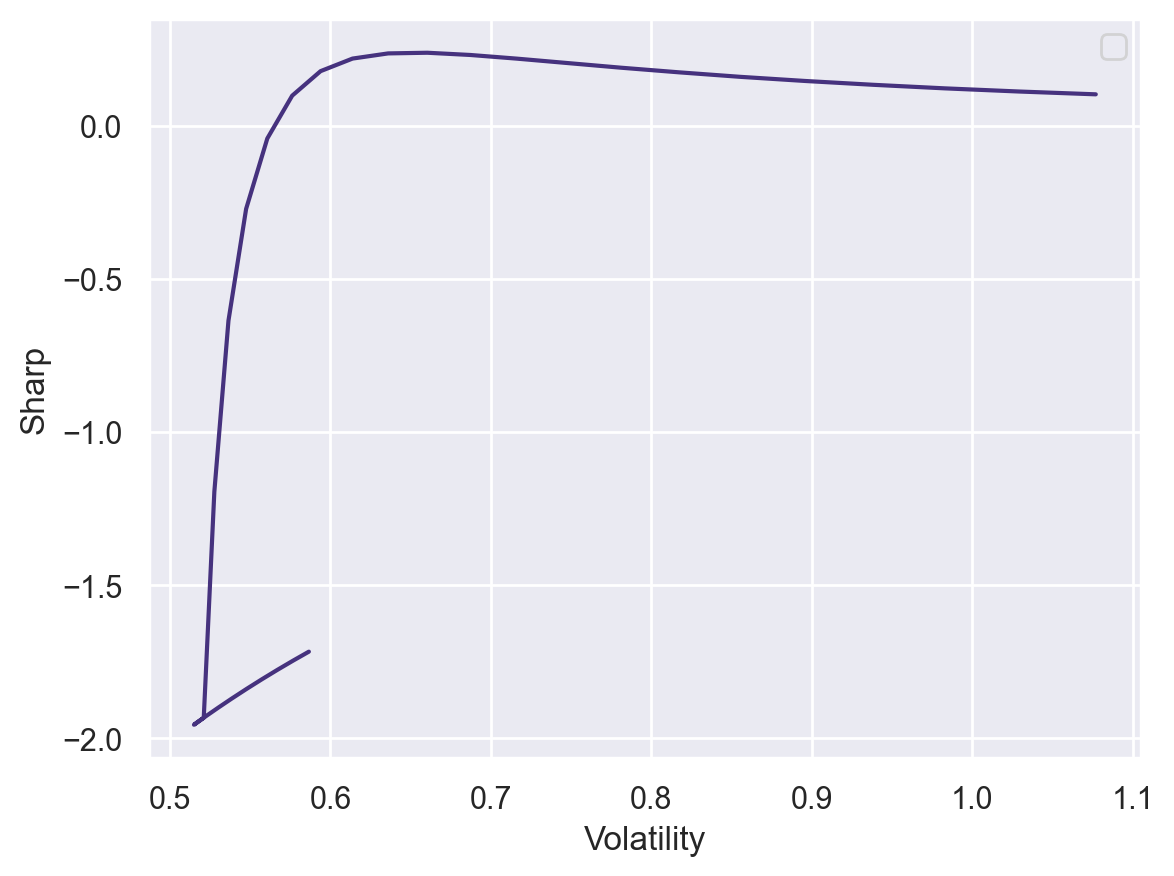

In [59]:
plt.plot(df_sber['IV'], df_sber['Sharp Ratio'])
plt.legend()
plt.xlabel('Volatility')
plt.ylabel('Sharp')
plt.show()

# fig.savefig('IV_vs_Sharp_SBER.png')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


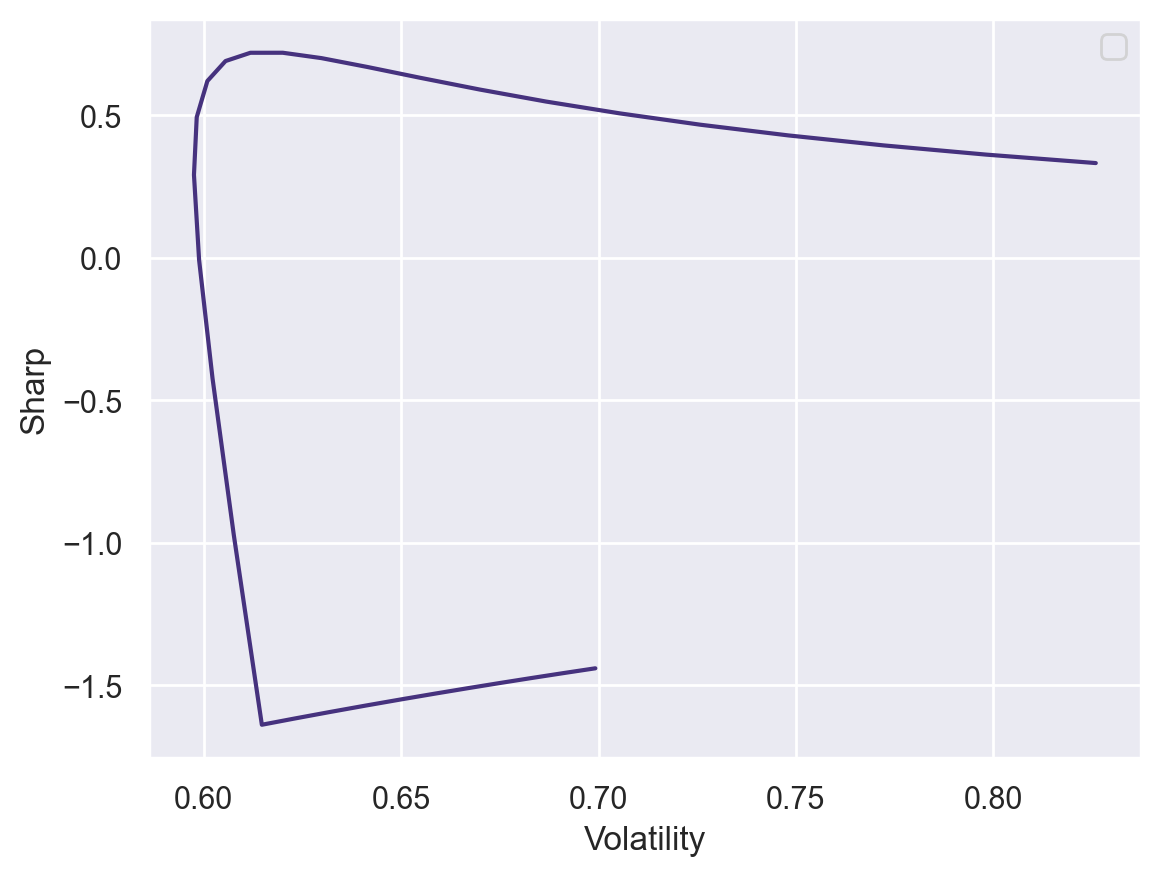

In [60]:
plt.plot(df_lkoh['IV'], df_lkoh['Sharp Ratio'])
plt.legend()
plt.xlabel('Volatility')
plt.ylabel('Sharp')
plt.show()

# fig.savefig('IV_vs_Sharp_LKOH.png')